In [6]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline 

In [7]:
train_data  = pd.read_csv("titanicTrain.csv")
test_data   = pd.read_csv("titanicQuestion.csv")

In [8]:
train_data['one'] = 1
train_data.shape

(1310, 15)

* #### 刪掉多出來的資料

In [9]:
train_data.drop(train_data.index[1000:1310], inplace=True)  

In [9]:
train_data.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


survival - Survival (0 = No; 1 = Yes)

class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)

sibsp - Number of Siblings/Spouses Aboard ()兄弟姐妹或配偶

parch - Number of Parents/Children Aboard 

fare - Passenger Fare (票價)

cabin - Cabin (船昌號碼)
登船港口
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

boat - Lifeboat (if survived)

body - Body number (if did not survive and body was recovered)

embrked 登船港口

https://github.com/awesomedata/awesome-public-datasets/issues/351
https://data.world/nrippner/titanic-disaster-dataset


* ## 拆分成有存活和沒有存活

In [10]:
train_survived = train_data[train_data.survived == 1]
train_dead = train_data[train_data.survived == 0]

In [22]:

print(train_survived.shape)
print(train_dead.shape)

(423, 15)
(577, 15)


# 6歲以下(含)生存率達87.5%

In [5]:
train_data[(train_data.age <= 6) & (train_data.survived == 1)]['one'].count()\
/train_data[(train_data.age < 6)]['one'].count()

0.875

## 洞察： 6歲以下存活率高，之後6歲以下可以都設為生存


* ### 查看各年齡的死亡和存活人數的折線圖

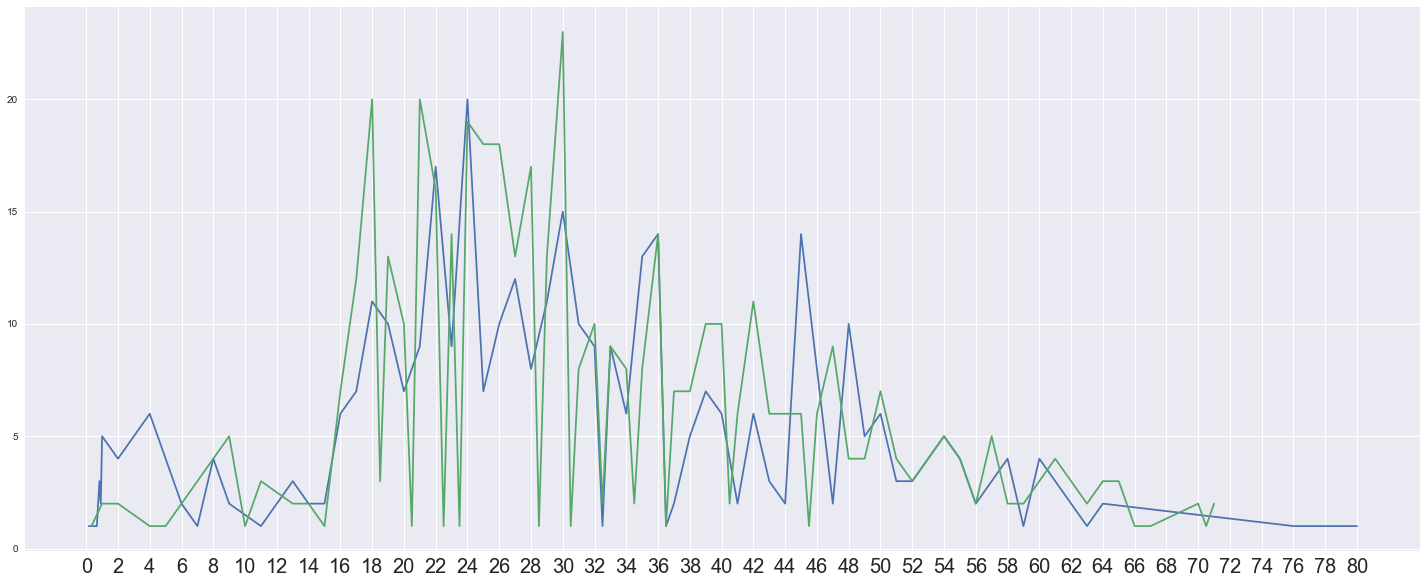

In [12]:
matplotlib.rc('xtick', labelsize=20) 
plt.figure(figsize=(25,10))

age_survived_group = train_survived.groupby(by='age')['one'].sum()
age_dead_group = train_dead.groupby(by='age')['one'].sum()

plt.xticks(range(0,81,2))
plt.plot(age_survived_group)
plt.plot(age_dead_group)

In [14]:
train_data[train_data.parch.isnull()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,one


In [19]:
train_data['sibsp'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [20]:
train_data['parch'].unique(

array([ 0.,  2.,  1.,  4.,  3.,  5.,  6.])

* ### parch  都有值  沒有null

## 有個別數量的兄弟姐妹或配偶的乘客的存活率

In [31]:
parch_survived = train_data.groupby(by='parch')['survived'].sum()
parch_dead = train_dead.groupby(by='parch')['one'].sum()
parch_survived / (parch_survived + parch_dead)

parch
0.0    0.366142
1.0    0.653846
2.0    0.571429
3.0    0.625000
4.0    0.333333
5.0    0.250000
6.0    0.000000
dtype: float64

## 有個別數量的父母或是子代的存活率

In [32]:
sibsp_survived = train_data.groupby(by='sibsp')['survived'].sum()
sibsp_dead = train_dead.groupby(by='sibsp')['one'].sum()
sibsp_survived / (sibsp_survived + sibsp_dead)

sibsp
0.0    0.383808
1.0    0.525926
2.0    0.470588
3.0    0.545455
4.0    0.250000
5.0    0.000000
dtype: float64

## 目標： 從pclass查看個別存活率

In [20]:
pclass_survived = train_survived.groupby(by='pclass')['one'].sum()
pclass_dead = train_dead.groupby(by='pclass')['one'].sum()
pclass_survived / (pclass_survived + pclass_dead)

pclass
1.0    0.619195
2.0    0.429603
3.0    0.260000
Name: one, dtype: float64

## insight: 如果pclass(船票等級)為3乘客的存活率只有26%，換句話說死亡率是74%

## 目標： 從性別查看個別的存活率

In [19]:
sex_survived = train_survived.groupby(by='sex')['one'].sum()
sex_dead = train_dead.groupby(by='sex')['one'].sum()
sex_survived / (sex_survived + sex_dead)

sex
female    0.781671
male      0.211447
Name: one, dtype: float64

## insight: 女性的存活率多於男性的存活率三倍之餘，為78.1671%

In [16]:
print(train_survived.shape)
print(train_dead.shape)

(423, 15)
(577, 15)


## 目標：以pclass 等於3 以及性別等於男性來當作判別死亡的標準

In [19]:
print(train_dead[(train_dead.pclass ==3) | (train_dead.sex == 'male')].shape[0]  / 577)
#如果用上面的兩個條件當作判定死亡的標準  可以抓出560個死亡案例

0.9705372616984402


# 如果以pclass 等於3 以及性別等於男性來當作判別死亡的標準，在training_data正確率高達97.05%

## 目標：以pclass 不等於3 以及性別等於女性來當作判別存活的標準

In [31]:
train_survived[(train_survived.pclass !=3) | (train_survived.sex == 'female')].shape[0]  / 423
#如果用上面的兩個條件當作判定存活的標準   會誤殺12%的人

0.8888888888888888

# 如果以pclass 不等於3 以及性別等於女性來當作判別存活的標準，在training_data正確率高達88.88%

In [35]:
train_survived.groupby(by='cabin')['one'].sum()

cabin
A11                1
A16                1
A20                1
A23                1
A26                1
A31                1
A34                3
A6                 1
A9                 1
B101               1
B18                2
B20                2
B22                1
B26                1
B28                2
B3                 1
B35                2
B36                1
B39                1
B4                 1
B41                2
B42                1
B45                2
B49                2
B5                 2
B50                1
B51 B53 B55        2
B52 B54 B56        1
B57 B59 B63 B66    4
B58 B60            2
                  ..
D40                1
D45                1
D47                1
D49                1
D56                1
D7                 1
D9                 1
E101               3
E12                1
E17                1
E24                2
E25                2
E31                1
E33                2
E34                3
E36                1
E39 E41

## 查看各個不同的 embarked(登船港口)的生存率

In [56]:
train_survived[train_survived['embarked'].notnull()].groupby(by='embarked')['one'].sum()\
/(train_survived[train_survived['embarked'].notnull()].groupby(by='embarked')['one'].sum() + \
 train_dead[train_dead['embarked'].notnull()].groupby(by='embarked')['one'].sum())



embarked
C    0.575893
Q    0.295775
S    0.385491
Name: one, dtype: float64

* 計算  embarked ： C Q S  各有多少人

In [54]:
# embarked 有值的才當作統計CQS各有多少人
train_data[train_data['embarked'].notnull()].groupby(by='embarked')['one'].sum()

embarked
C    224
Q     71
S    703
Name: one, dtype: int64

In [35]:
train_data[train_data['cabin'].isnull()]['one'].sum()    #有多少'cabin是空的

717

# 以下是嘗試用SVM預測

In [6]:
train_data.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest', 'one'],
      dtype='object')

In [53]:
test_data   = pd.read_csv("titanicQuestion.csv")
train_data  = pd.read_csv("titanicTrain.csv")
train_data.drop(train_data.index[1000:1310], inplace=True)  #delete rest of value


def classifier(row):
    if row['sex']=='female':
        return 0
    elif row['sex']=='male':
        return 1

train_data = train_data[train_data.age.notnull()]
train_data.iloc[:, [3]]= train_data.iloc[:, [3]].apply(classifier, axis=1)

X = train_data.iloc[:, [0, 3]].values  
y = train_data.iloc[:, 1].values       

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [46]:
TT = sc.transform(TT)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [54]:
TT_pred = classifier.predict(TT)

In [51]:
TT = X

In [56]:
TT_pred

array([ 1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0

In [57]:
test_data = pd.read_csv("titanicQuestion.csv")

In [58]:
test_data.age.notnull().index

RangeIndex(start=0, stop=309, step=1)

In [161]:
len(TT_pred)

185

In [167]:
test_data   = pd.read_csv("titanicQuestion.csv")
#train_data.drop(train_data.index[1000:1310], inplace=True)  #delete rest of value


def classifier(row):
    if row['sex']=='female':
        return 0
    elif row['sex']=='male':
        return 1

test_data = test_data[test_data.age.notnull()]
test_data.iloc[:, [3]]= test_data.iloc[:, [3]].apply(classifier, axis=1)


X = test_data.iloc[:, [0, 3]].values  
#y = test_data.iloc[:, 1].values       

In [199]:
TT_pred

array([ 1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0

In [211]:
test_da = pd.read_csv("titanicQuestion.csv")
test_da["survived"] = 0 

In [213]:
test_da

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,3,0,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,NaN,NaN,NaN
1,3,0,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
2,3,0,"McCoy, Miss. Alicia",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
3,3,0,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
4,3,0,"McDermott, Miss. Brigdet Delia",female,NaN,0,0,330932,7.7875,NaN,Q,13,NaN,NaN
5,3,0,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q,NaN,NaN,NaN
6,3,0,"McGovern, Miss. Mary",female,NaN,0,0,330931,7.8792,NaN,Q,13,NaN,NaN
7,3,0,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,NaN,NaN,NaN
8,3,0,"McGowan, Miss. Katherine",female,35.0,0,0,9232,7.7500,NaN,Q,NaN,NaN,NaN
9,3,0,"McMahon, Mr. Martin",male,NaN,0,0,370372,7.7500,NaN,Q,NaN,NaN,NaN


In [215]:
for c in range(len(i)):
    test_da.survived.iloc[i[c]] = TT_pred[c]
    #print(i[c] + '  ' +TT_pred[c] )

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [216]:
test_da

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,3,0.0,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,NaN,NaN,NaN
1,3,0.0,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
2,3,0.0,"McCoy, Miss. Alicia",female,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
3,3,0.0,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q,16,NaN,NaN
4,3,0.0,"McDermott, Miss. Brigdet Delia",female,NaN,0,0,330932,7.7875,NaN,Q,13,NaN,NaN
5,3,0.0,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q,NaN,NaN,NaN
6,3,0.0,"McGovern, Miss. Mary",female,NaN,0,0,330931,7.8792,NaN,Q,13,NaN,NaN
7,3,1.0,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,NaN,NaN,NaN
8,3,1.0,"McGowan, Miss. Katherine",female,35.0,0,0,9232,7.7500,NaN,Q,NaN,NaN,NaN
9,3,0.0,"McMahon, Mr. Martin",male,NaN,0,0,370372,7.7500,NaN,Q,NaN,NaN,NaN


In [217]:
order = test_da.to_csv("Answer.csv", index = False, encoding="utf-8")